# Core Workflow: Applying Model
Load existing, trained model from file and apply it to imagery (and other inputs) in order to generate a comprehensive LULC raster covering the entire urban extent of a given city. Allows user to preview LULC tiles and compare against VIR component of input stack.  
  
Date: 2018-09-17  
Author: Peter Kerins

### Import statements
(may be over-inclusive)

In [1]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf
import keras

import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

# how do change this from manual?
sys.path.append('/home/Peter.Kerins/UrbanLandUse/utils')
print sys.path

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow


Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils']


### Set key variables

In [2]:
place = 'hyderabad'

data_root='/data/phase_iii/'
data_path=data_root+place+'/'

bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution=10  # Lx:15 S2:10

s1_bands=['vv','vh']; s1_suffix='VVVH'
s1_resolution = resolution

tile_resolution = resolution
tile_size = 256
tile_pad = 16

categories = [0,1,4,6]

# NYU AoUE land use/land cover categories
category_label = {0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

### Load and inspect study area

hyderabad Hyderabad
>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyArea.shp
INFO: Open of `/data/phase_iii/hyderabad/Hyderabad_studyArea.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Hyderabad_studyArea
Metadata:
  DBF_DATE_LAST_UPDATE=2016-07-17
Geometry: Polygon
Feature Count: 1
Extent: (195959.428255, 1900659.020753) - (262570.313581, 1963477.496879)
Layer SRS WKT:
PROJCS["WGS_1984_UTM_Zone_44N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137.0,298.257223563]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0],
    PARAMETER["central_meridian",81.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["latitude_of_origin",0.0],
    UNIT["Meter",1.0]]
Id: Integer (6.0)

>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyAreaEPSG4326.shp
INFO: Open of `/data

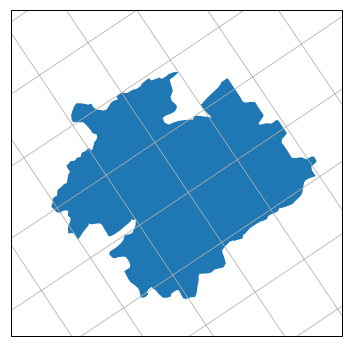

In [3]:
print place, place.title() # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
#print polygon
#pprint(shape)
place_bbox = shape['bbox']
#print bbox

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print "center co-ordinates", clat, clon
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 458
[u'geometry', u'type', u'properties']
tile022 {u'type': u'Polygon', u'coordinates': [[[78.1775006012039, 17.529165535205387], [78.20460181878519, 17.52954978485592], [78.20420289377427, 17.555551127046854], [78.17709782110293, 17.55516627151902], [78.1775006012039, 17.529165535205387]]]}


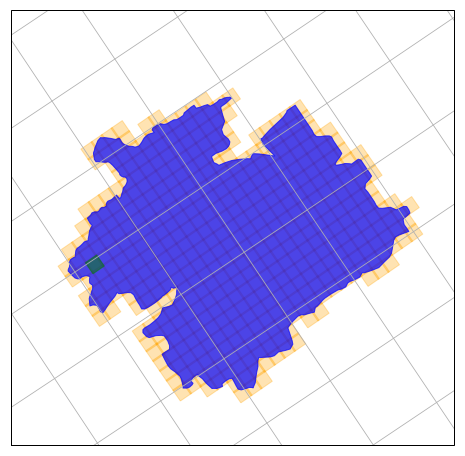

In [4]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Set input stack and model parameters

In [6]:
window = 7    # width of square window

bands_vir=bands[:-1]
bands_sar=s1_bands
bands_ndvi=None
bands_ndbi=None
bands_osm=None

haze_removal = False

image_suffix = 'A'

model_id = 'phase_iii_demo_3'

In [7]:
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print stack_label, feature_count

vir+sar 8


### Load model objects

In [8]:
scaler_filename = data_root+'models/'+model_id+'_scaler.pkl'
model_filename  = data_root+'models/'+model_id+'_SVM.pkl'
network_filename = data_root+'models/'+model_id+'_DLv3.hd5'

with open(scaler_filename, "rb") as f:
    scaler = pickle.load(f)
f.close()

with open(model_filename, "rb") as f:
    model = pickle.load(f)
f.close()

network = load_model(network_filename)

### Apply model to classify LULC

In [9]:
util_workflow.classify_tiles(data_path, place, tiles, image_suffix,
        window, stack_label, feature_count, model_id, scaler, network,
        bands_vir=bands_vir,
        bands_sar=bands_sar, bands_ndvi=None, bands_ndbi=None, bands_osm=None,
        haze_removal=False, categories=categories)

Feature count: 8
Stack label:  vir+sar
tile 0 load VIR image
vir shape: (7, 288, 288)
5569 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2155 )
vir band 1 into imn band 1 ( 0.0 - 0.2232 )
vir band 2 into imn band 2 ( 0.0 - 0.2465 )
vir band 3 into imn band 3 ( 0.0 - 0.3755 )
vir band 4 into imn band 4 ( 0.0 - 0.3242 )
vir band 5 into imn band 5 ( 0.0 - 0.25 )
tile 0 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 65452
1 70
2 2
3 12
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile000_phase_iii_demo_3_lulc_A.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 0 done
tile 1 load VIR image
vir shape: (7, 288, 288)
34215 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2658 )
vir band 1 into imn band 1 ( 0.0 - 0.2813 )
vir band 2 into imn b

.....................done
0 56397
1 6020
2 2564
3 555
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile010_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.63264525 0.19922869 0.03969046 0.12843557 0.         0.63264525]
tile 10 done
tile 11 load VIR image
vir shape: (7, 288, 288)
12652 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2662 )
vir band 1 into imn band 1 ( 0.0 - 0.2801 )
vir band 2 into imn band 2 ( 0.0 - 0.328 )
vir band 3 into imn band 3 ( 0.0 - 0.3454 )
vir band 4 into imn band 4 ( 0.0 - 0.3869 )
vir band 5 into imn band 5 ( 0.0 - 0.3207 )
tile 11 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 65124
1 365
2 23
3 24
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile011_phase_iii_demo_3_lulc_A.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 11 done
tile 12 l

.....................done
0 58997
1 4156
2 2115
3 268
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile021_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.5296959  0.2153136  0.08103343 0.17395702 0.         0.5296959 ]
tile 21 done
tile 22 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1154 - 0.2864 )
vir band 1 into imn band 1 ( 0.0915 - 0.3248 )
vir band 2 into imn band 2 ( 0.0738 - 0.3816 )
vir band 3 into imn band 3 ( 0.0744 - 0.4212 )
vir band 4 into imn band 4 ( 0.0292 - 0.6664 )
vir band 5 into imn band 5 ( 0.0208 - 1.0 )
tile 22 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.007843138 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 45586
1 12251
2 5961
3 1738
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile022_phase_iii_demo_3_lulc_A.tif
Y_full sample [1. 

.....................done
0 63942
1 1420
2 103
3 71
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile032_phase_iii_demo_3_lulc_A.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 32 done
tile 33 load VIR image
vir shape: (7, 288, 288)
31889 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2232 )
vir band 1 into imn band 1 ( 0.0 - 0.2153 )
vir band 2 into imn band 2 ( 0.0 - 0.2531 )
vir band 3 into imn band 3 ( 0.0 - 0.3693 )
vir band 4 into imn band 4 ( 0.0 - 0.46 )
vir band 5 into imn band 5 ( 0.0 - 0.3597 )
tile 33 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 64066
1 1234
2 91
3 145
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile033_phase_iii_demo_3_lulc_A.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 33 done
tile 34 load VIR image
vir shape: (7, 288, 288)
77287 stud

.....................done
0 64285
1 1057
2 106
3 88
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile043_phase_iii_demo_3_lulc_A.tif
Y_full sample [9.9999690e-01 3.1046168e-06 2.0434985e-11 5.5447084e-33 0.0000000e+00
 9.9999690e-01]
tile 43 done
tile 44 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1098 - 0.2791 )
vir band 1 into imn band 1 ( 0.0922 - 0.2965 )
vir band 2 into imn band 2 ( 0.08 - 0.3582 )
vir band 3 into imn band 3 ( 0.1011 - 0.4133 )
vir band 4 into imn band 4 ( 0.1288 - 0.4398 )
vir band 5 into imn band 5 ( 0.0852 - 0.321 )
tile 44 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 64426
1 885
2 171
3 54
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile044_phase_iii_demo_3_lulc_A.tif
Y_full

.....................done
0 59656
1 4462
2 681
3 737
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile053_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.84879065 0.10151599 0.00117826 0.04851505 0.         0.84879065]
tile 53 done
tile 54 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1106 - 0.2973 )
vir band 1 into imn band 1 ( 0.0901 - 0.3149 )
vir band 2 into imn band 2 ( 0.0753 - 0.358 )
vir band 3 into imn band 3 ( 0.0682 - 0.377 )
vir band 4 into imn band 4 ( 0.0364 - 0.507 )
vir band 5 into imn band 5 ( 0.026 - 0.4906 )
tile 54 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 56140
1 7443
2 1108
3 845
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile054_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.81411

.....................done
0 62990
1 1889
2 563
3 94
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile063_phase_iii_demo_3_lulc_A.tif
Y_full sample [1.0000000e+00 4.3628107e-10 1.8082337e-29 0.0000000e+00 0.0000000e+00
 1.0000000e+00]
tile 63 done
tile 64 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1127 - 0.2869 )
vir band 1 into imn band 1 ( 0.097 - 0.3022 )
vir band 2 into imn band 2 ( 0.0813 - 0.3473 )
vir band 3 into imn band 3 ( 0.1226 - 0.4049 )
vir band 4 into imn band 4 ( 0.155 - 0.439 )
vir band 5 into imn band 5 ( 0.0738 - 1.0 )
tile 64 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 63778
1 1462
2 212
3 84
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile064_phase_iii_demo_3_lulc_A.tif
Y_full s

.....................done
0 45633
1 10438
2 7718
3 1747
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile073_phase_iii_demo_3_lulc_A.tif
Y_full sample [3.1825334e-01 6.0283393e-01 9.8365861e-05 7.8814410e-02 1.0000000e+00
 6.0283393e-01]
tile 73 done
tile 74 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1113 - 0.2323 )
vir band 1 into imn band 1 ( 0.0871 - 0.2421 )
vir band 2 into imn band 2 ( 0.069 - 0.2812 )
vir band 3 into imn band 3 ( 0.0726 - 0.374 )
vir band 4 into imn band 4 ( 0.0323 - 0.4198 )
vir band 5 into imn band 5 ( 0.0182 - 0.3626 )
tile 74 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 46150
1 11078
2 7228
3 1080
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile074_phase_iii_demo_3_lulc_A.

.....................done
0 61333
1 2954
2 1001
3 248
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile083_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.74173456 0.187414   0.00384715 0.06700422 0.         0.74173456]
tile 83 done
tile 84 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1104 - 0.3087 )
vir band 1 into imn band 1 ( 0.0965 - 0.3342 )
vir band 2 into imn band 2 ( 0.0801 - 0.377 )
vir band 3 into imn band 3 ( 0.1201 - 0.4506 )
vir band 4 into imn band 4 ( 0.1426 - 0.4444 )
vir band 5 into imn band 5 ( 0.0713 - 0.3561 )
tile 84 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 63220
1 1843
2 378
3 95
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile084_phase_iii_demo_3_lulc_A.tif
Y_full sample [1.000

.....................done
0 39417
1 15774
2 9348
3 997
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile093_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.44793728 0.47109905 0.00539891 0.07556477 1.         0.47109905]
tile 93 done
tile 94 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.113 - 0.3035 )
vir band 1 into imn band 1 ( 0.0919 - 0.3071 )
vir band 2 into imn band 2 ( 0.0692 - 0.3565 )
vir band 3 into imn band 3 ( 0.0639 - 0.4261 )
vir band 4 into imn band 4 ( 0.0224 - 0.4367 )
vir band 5 into imn band 5 ( 0.0151 - 0.3855 )
tile 94 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.007843138 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 30582
1 13241
2 18341
3 3372
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile094_phase_iii_demo_3_lulc_A.tif
Y_full sample 

.....................done
0 64986
1 449
2 58
3 43
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile103_phase_iii_demo_3_lulc_A.tif
Y_full sample [9.84552979e-01 5.66701528e-05 1.11316484e-10 1.53903468e-02
 0.00000000e+00 9.84552979e-01]
tile 103 done
tile 104 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1082 - 0.3186 )
vir band 1 into imn band 1 ( 0.0929 - 0.3458 )
vir band 2 into imn band 2 ( 0.0773 - 0.3805 )
vir band 3 into imn band 3 ( 0.0938 - 0.4553 )
vir band 4 into imn band 4 ( 0.0803 - 0.4524 )
vir band 5 into imn band 5 ( 0.0424 - 0.4001 )
tile 104 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.007843138 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 62658
1 2040
2 167
3 671
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile104_phase_iii_demo_3_lulc_

.....................done
0 38752
1 9571
2 15091
3 2122
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile113_phase_iii_demo_3_lulc_A.tif
Y_full sample [1.0000000e+00 2.4741156e-09 1.1259749e-36 0.0000000e+00 0.0000000e+00
 1.0000000e+00]
tile 113 done
tile 114 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1108 - 0.2916 )
vir band 1 into imn band 1 ( 0.0919 - 0.2842 )
vir band 2 into imn band 2 ( 0.0726 - 0.3382 )
vir band 3 into imn band 3 ( 0.0901 - 0.4131 )
vir band 4 into imn band 4 ( 0.0927 - 0.4467 )
vir band 5 into imn band 5 ( 0.0437 - 0.4171 )
tile 114 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 21405
1 14569
2 25977
3 3585
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile114_phase_iii_demo_3_l

.....................done
0 64573
1 668
2 180
3 115
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile124_phase_iii_demo_3_lulc_A.tif
Y_full sample [9.9984968e-01 1.5029886e-04 3.5150407e-09 2.5286647e-14 0.0000000e+00
 9.9984968e-01]
tile 124 done
tile 125 load VIR image
vir shape: (7, 288, 288)
82017 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2748 )
vir band 1 into imn band 1 ( 0.0 - 0.2616 )
vir band 2 into imn band 2 ( 0.0 - 0.3345 )
vir band 3 into imn band 3 ( 0.0 - 0.4299 )
vir band 4 into imn band 4 ( 0.0 - 0.4701 )
vir band 5 into imn band 5 ( 0.0 - 0.3947 )
tile 125 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 62011
1 2177
2 1007
3 341
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile125_phase_iii_demo_3_lulc_A.tif
Y_full sample [1.0000000e+00 1.

.....................done
0 39182
1 16229
2 7207
3 2918
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile134_phase_iii_demo_3_lulc_A.tif
Y_full sample [1.0000000e+00 1.5157021e-14 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0000000e+00]
tile 134 done
tile 135 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1083 - 0.3076 )
vir band 1 into imn band 1 ( 0.0833 - 0.3363 )
vir band 2 into imn band 2 ( 0.0646 - 0.3973 )
vir band 3 into imn band 3 ( 0.0625 - 0.4431 )
vir band 4 into imn band 4 ( 0.0303 - 0.4738 )
vir band 5 into imn band 5 ( 0.0188 - 0.9057 )
tile 135 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.019607844 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 50783
1 9737
2 3887
3 1129
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile135_phase_iii_demo_3_lul

.....................done
0 65184
1 352
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile144_phase_iii_demo_3_lulc_A.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 144 done
tile 145 load VIR image
vir shape: (7, 288, 288)
57446 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1838 )
vir band 1 into imn band 1 ( 0.0 - 0.1876 )
vir band 2 into imn band 2 ( 0.0 - 0.237 )
vir band 3 into imn band 3 ( 0.0 - 0.3367 )
vir band 4 into imn band 4 ( 0.0 - 0.4514 )
vir band 5 into imn band 5 ( 0.0 - 0.3212 )
tile 145 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.0 - 0.9019608 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 64304
1 1094
2 124
3 14
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile145_phase_iii_demo_3_lulc_A.tif
Y_full sample [9.9570304e-01 1.1217331e-03 1.6213660e-08 3.1753001e-03 0.0000000e+00
 9.9570304e-01]
tile 1

.....................done
0 55780
1 5609
2 3291
3 856
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile154_phase_iii_demo_3_lulc_A.tif
Y_full sample [9.8880821e-01 2.3588408e-03 1.0334122e-07 8.8328952e-03 0.0000000e+00
 9.8880821e-01]
tile 154 done
tile 155 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1115 - 0.2803 )
vir band 1 into imn band 1 ( 0.095 - 0.2825 )
vir band 2 into imn band 2 ( 0.0764 - 0.3381 )
vir band 3 into imn band 3 ( 0.0768 - 0.3812 )
vir band 4 into imn band 4 ( 0.04 - 0.4687 )
vir band 5 into imn band 5 ( 0.0255 - 0.4151 )
tile 155 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 57268
1 5692
2 1541
3 1035
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile155_phase_iii_demo_3_lulc_A.t

.....................done
0 54875
1 5020
2 4708
3 933
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile164_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.762447   0.15627746 0.00409184 0.07718373 0.         0.762447  ]
tile 164 done
tile 165 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.114 - 0.254 )
vir band 1 into imn band 1 ( 0.0907 - 0.2698 )
vir band 2 into imn band 2 ( 0.0733 - 0.3137 )
vir band 3 into imn band 3 ( 0.0602 - 0.3578 )
vir band 4 into imn band 4 ( 0.0349 - 0.4208 )
vir band 5 into imn band 5 ( 0.0187 - 0.3656 )
tile 165 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 63484
1 1208
2 422
3 422
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile165_phase_iii_demo_3_lulc_A.tif
Y_full sample [1.

.....................done
0 58906
1 4685
2 598
3 1347
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile174_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.8764524  0.05349658 0.00479703 0.06525398 0.         0.8764524 ]
tile 174 done
tile 175 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.106 - 0.2508 )
vir band 1 into imn band 1 ( 0.0883 - 0.2635 )
vir band 2 into imn band 2 ( 0.0648 - 0.3173 )
vir band 3 into imn band 3 ( 0.0618 - 0.4408 )
vir band 4 into imn band 4 ( 0.0229 - 0.4362 )
vir band 5 into imn band 5 ( 0.0123 - 0.3882 )
tile 175 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.007843138 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 45776
1 9191
2 8056
3 2513
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile175_phase_iii_demo_3_lulc_A.tif
Y_full sample 

.....................done
0 26428
1 13434
2 21499
3 4175
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile184_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.01048787 0.9391459  0.00543307 0.04493316 1.         0.9391459 ]
tile 184 done
tile 185 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1189 - 0.273 )
vir band 1 into imn band 1 ( 0.0946 - 0.2899 )
vir band 2 into imn band 2 ( 0.0746 - 0.3496 )
vir band 3 into imn band 3 ( 0.0563 - 0.4005 )
vir band 4 into imn band 4 ( 0.019 - 0.466 )
vir band 5 into imn band 5 ( 0.0128 - 0.4227 )
tile 185 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.007843138 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 21694
1 9913
2 28012
3 5917
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile185_phase_iii_demo_3_lulc_A.tif
Y_full sampl

.....................done
0 65166
1 355
2 3
3 12
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile194_phase_iii_demo_3_lulc_A.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 194 done
tile 195 load VIR image
vir shape: (7, 288, 288)
849 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1567 )
vir band 1 into imn band 1 ( 0.0 - 0.153 )
vir band 2 into imn band 2 ( 0.0 - 0.1887 )
vir band 3 into imn band 3 ( 0.0 - 0.2622 )
vir band 4 into imn band 4 ( 0.0 - 0.3175 )
vir band 5 into imn band 5 ( 0.0 - 0.224 )
tile 195 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.0 - 0.4392157 )
sar band 1 into imn band 7 ( 0.0 - 0.3529412 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 65519
1 16
3 1
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile195_phase_iii_demo_3_lulc_A.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 195 done
tile 196 load VIR image
vir shape: (7, 288, 288)
41338 s

.....................done
0 24563
1 13295
2 25546
3 2132
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile204_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.00308532 0.01837775 0.8184443  0.1600926  2.         0.8184443 ]
tile 204 done
tile 205 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1149 - 0.3117 )
vir band 1 into imn band 1 ( 0.0939 - 0.3326 )
vir band 2 into imn band 2 ( 0.0747 - 0.4021 )
vir band 3 into imn band 3 ( 0.0621 - 0.4526 )
vir band 4 into imn band 4 ( 0.0269 - 0.4227 )
vir band 5 into imn band 5 ( 0.0185 - 0.3696 )
tile 205 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.019607844 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 11964
1 10060
2 37520
3 5992
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile205_phase_iii_demo_3_lulc_A.tif
Y_full s

.....................done
0 58357
1 3621
2 2493
3 1065
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile214_phase_iii_demo_3_lulc_A.tif
Y_full sample [9.99934077e-01 6.59715733e-05 1.01993187e-08 1.10517505e-10
 0.00000000e+00 9.99934077e-01]
tile 214 done
tile 215 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1116 - 0.3854 )
vir band 1 into imn band 1 ( 0.0925 - 0.4154 )
vir band 2 into imn band 2 ( 0.0758 - 0.5096 )
vir band 3 into imn band 3 ( 0.0733 - 0.5705 )
vir band 4 into imn band 4 ( 0.0477 - 0.6307 )
vir band 5 into imn band 5 ( 0.0265 - 0.538 )
tile 215 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 60425
1 4637
2 218
3 256
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile215_phase_iii_demo_3_l

.....................done
0 31269
1 11031
2 20935
3 2301
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile224_phase_iii_demo_3_lulc_A.tif
Y_full sample [1.00000e+00 6.20013e-14 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00]
tile 224 done
tile 225 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1084 - 0.2586 )
vir band 1 into imn band 1 ( 0.0882 - 0.2721 )
vir band 2 into imn band 2 ( 0.0662 - 0.3077 )
vir band 3 into imn band 3 ( 0.0667 - 0.4314 )
vir band 4 into imn band 4 ( 0.0236 - 0.3828 )
vir band 5 into imn band 5 ( 0.0122 - 0.3781 )
tile 225 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.023529412 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 17078
1 8648
2 36050
3 3760
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile225_phase_iii_demo_3_lulc_A.tif
Y_f

.....................done
0 52428
1 6670
2 5050
3 1388
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile234_phase_iii_demo_3_lulc_A.tif
Y_full sample [9.9904913e-01 8.8709133e-04 2.8099311e-07 6.3481020e-05 0.0000000e+00
 9.9904913e-01]
tile 234 done
tile 235 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1188 - 0.2916 )
vir band 1 into imn band 1 ( 0.0982 - 0.303 )
vir band 2 into imn band 2 ( 0.0893 - 0.3565 )
vir band 3 into imn band 3 ( 0.089 - 0.4001 )
vir band 4 into imn band 4 ( 0.0331 - 0.4893 )
vir band 5 into imn band 5 ( 0.0211 - 0.4323 )
tile 235 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.007843138 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 56265
1 5450
2 1750
3 2071
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile235_phase_iii_demo_3_lulc_A

.....................done
0 20661
1 10748
2 30440
3 3687
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile244_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.02219864 0.05134004 0.76258445 0.16387689 2.         0.76258445]
tile 244 done
tile 245 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1066 - 0.5259 )
vir band 1 into imn band 1 ( 0.0876 - 0.4829 )
vir band 2 into imn band 2 ( 0.0663 - 0.5158 )
vir band 3 into imn band 3 ( 0.0639 - 0.6689 )
vir band 4 into imn band 4 ( 0.0227 - 0.4551 )
vir band 5 into imn band 5 ( 0.0126 - 0.4356 )
tile 245 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.007843138 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 8521
1 10161
2 42899
3 3955
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile245_phase_iii_demo_3_lulc_A.tif
Y_full sa

.....................done
0 60292
1 2587
2 2230
3 427
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile254_phase_iii_demo_3_lulc_A.tif
Y_full sample [1.000000e+00 1.644967e-12 0.000000e+00 0.000000e+00 0.000000e+00
 1.000000e+00]
tile 254 done
tile 255 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1138 - 0.3003 )
vir band 1 into imn band 1 ( 0.0964 - 0.3239 )
vir band 2 into imn band 2 ( 0.082 - 0.3772 )
vir band 3 into imn band 3 ( 0.0992 - 0.4021 )
vir band 4 into imn band 4 ( 0.0791 - 0.5412 )
vir band 5 into imn band 5 ( 0.0484 - 0.5338 )
tile 255 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 60017
1 4167
2 956
3 396
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile255_phase_iii_demo_3_lulc_A.tif
Y_f

.....................done
0 58124
1 5013
2 1714
3 685
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile264_phase_iii_demo_3_lulc_A.tif
Y_full sample [8.3074522e-01 1.4127618e-01 2.5799236e-04 2.7720625e-02 0.0000000e+00
 8.3074522e-01]
tile 264 done
tile 265 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1133 - 0.2948 )
vir band 1 into imn band 1 ( 0.0931 - 0.3198 )
vir band 2 into imn band 2 ( 0.074 - 0.3641 )
vir band 3 into imn band 3 ( 0.0836 - 0.434 )
vir band 4 into imn band 4 ( 0.0507 - 0.6481 )
vir band 5 into imn band 5 ( 0.0287 - 1.0 )
tile 265 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 37375
1 5159
2 21502
3 1500
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile265_phase_iii_demo_3_lulc_A.ti

.....................done
0 47537
1 7480
2 8756
3 1763
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile274_phase_iii_demo_3_lulc_A.tif
Y_full sample [2.2733297e-33 1.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
 1.0000000e+00]
tile 274 done
tile 275 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1132 - 0.264 )
vir band 1 into imn band 1 ( 0.0948 - 0.2824 )
vir band 2 into imn band 2 ( 0.0725 - 0.3267 )
vir band 3 into imn band 3 ( 0.0658 - 0.3968 )
vir band 4 into imn band 4 ( 0.0213 - 0.4107 )
vir band 5 into imn band 5 ( 0.0131 - 0.3911 )
tile 275 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.007843138 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 45048
1 10394
2 8191
3 1903
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile275_phase_iii_demo_3_lulc

.....................done
0 64004
1 1282
2 146
3 104
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile284_phase_iii_demo_3_lulc_A.tif
Y_full sample [1.0000000e+00 1.1679446e-10 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0000000e+00]
tile 284 done
tile 285 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1029 - 0.2811 )
vir band 1 into imn band 1 ( 0.0864 - 0.3055 )
vir band 2 into imn band 2 ( 0.0689 - 0.3624 )
vir band 3 into imn band 3 ( 0.0937 - 0.4291 )
vir band 4 into imn band 4 ( 0.1088 - 0.402 )
vir band 5 into imn band 5 ( 0.0603 - 0.3203 )
tile 285 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.019607844 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 61055
1 2685
2 1372
3 424
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile285_phase_iii_demo_3_lulc_A.t

.....................done
0 22779
1 15614
2 24901
3 2242
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile294_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.01534482 0.03786077 0.8044012  0.14239314 2.         0.8044012 ]
tile 294 done
tile 295 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1124 - 0.3019 )
vir band 1 into imn band 1 ( 0.0934 - 0.3121 )
vir band 2 into imn band 2 ( 0.0756 - 0.3521 )
vir band 3 into imn band 3 ( 0.0829 - 0.3779 )
vir band 4 into imn band 4 ( 0.0244 - 0.449 )
vir band 5 into imn band 5 ( 0.0132 - 0.4003 )
tile 295 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 15153
1 7854
2 40031
3 2498
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile295_phase_iii_demo_3_lulc_A.tif
Y_full sam

.....................done
0 64680
1 766
2 47
3 43
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile304_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.7587024  0.14026876 0.00888102 0.09214783 0.         0.7587024 ]
tile 304 done
tile 305 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.113 - 0.264 )
vir band 1 into imn band 1 ( 0.0956 - 0.2832 )
vir band 2 into imn band 2 ( 0.0832 - 0.3535 )
vir band 3 into imn band 3 ( 0.0955 - 0.4834 )
vir band 4 into imn band 4 ( 0.1302 - 0.434 )
vir band 5 into imn band 5 ( 0.0837 - 0.5419 )
tile 305 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 61409
1 2155
2 1736
3 236
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile305_phase_iii_demo_3_lulc_A.tif
Y_full sample [9.9249

.....................done
0 20385
1 12756
2 30583
3 1812
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile314_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.3116649  0.277099   0.2601794  0.15105663 0.         0.3116649 ]
tile 314 done
tile 315 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1147 - 0.2606 )
vir band 1 into imn band 1 ( 0.0937 - 0.2679 )
vir band 2 into imn band 2 ( 0.0779 - 0.3103 )
vir band 3 into imn band 3 ( 0.0821 - 0.3675 )
vir band 4 into imn band 4 ( 0.052 - 0.4289 )
vir band 5 into imn band 5 ( 0.0343 - 0.353 )
tile 315 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.019607844 - 1.0 )
sar band 1 into imn band 7 ( 0.019607844 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 38722
1 13075
2 12735
3 1004
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile315_phase_iii_demo_3_lulc_A.tif
Y_full sam

.....................done
0 65163
1 319
2 7
3 47
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile324_phase_iii_demo_3_lulc_A.tif
Y_full sample [1.0000000e+00 1.1842468e-12 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0000000e+00]
tile 324 done
tile 325 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1157 - 0.2508 )
vir band 1 into imn band 1 ( 0.0984 - 0.2616 )
vir band 2 into imn band 2 ( 0.0848 - 0.3034 )
vir band 3 into imn band 3 ( 0.099 - 0.4834 )
vir band 4 into imn band 4 ( 0.0893 - 0.4427 )
vir band 5 into imn band 5 ( 0.0584 - 0.3561 )
tile 325 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 61255
1 2590
2 1415
3 276
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile325_phase_iii_demo_3_lulc_A.tif
Y

.....................done
0 5766
1 5634
2 50644
3 3492
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile334_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.26515248 0.22723684 0.36458918 0.14302155 2.         0.36458918]
tile 334 done
tile 335 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1089 - 0.2949 )
vir band 1 into imn band 1 ( 0.0847 - 0.316 )
vir band 2 into imn band 2 ( 0.0655 - 0.362 )
vir band 3 into imn band 3 ( 0.053 - 0.4242 )
vir band 4 into imn band 4 ( 0.0253 - 0.4559 )
vir band 5 into imn band 5 ( 0.0131 - 0.4583 )
tile 335 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 34627
1 7333
2 22050
3 1526
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile335_phase_iii_demo_3_lulc_A.tif
Y_full sample 

.....................done
0 53165
1 6002
2 5061
3 1308
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile344_phase_iii_demo_3_lulc_A.tif
Y_full sample [9.8045957e-01 3.6917930e-03 1.0397089e-06 1.5847653e-02 0.0000000e+00
 9.8045957e-01]
tile 344 done
tile 345 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1127 - 0.3058 )
vir band 1 into imn band 1 ( 0.0922 - 0.335 )
vir band 2 into imn band 2 ( 0.0754 - 0.381 )
vir band 3 into imn band 3 ( 0.0662 - 0.4902 )
vir band 4 into imn band 4 ( 0.0362 - 0.4483 )
vir band 5 into imn band 5 ( 0.0238 - 0.4001 )
tile 345 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 56374
1 5575
2 2547
3 1040
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile345_phase_iii_demo_3_lulc_A

.....................done
0 40265
1 4400
2 19898
3 973
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile354_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.07736247 0.09609129 0.60638964 0.22015661 2.         0.60638964]
tile 354 done
tile 355 load VIR image
vir shape: (7, 288, 288)
82911 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2427 )
vir band 1 into imn band 1 ( 0.0 - 0.2514 )
vir band 2 into imn band 2 ( 0.0 - 0.2915 )
vir band 3 into imn band 3 ( 0.0 - 0.4383 )
vir band 4 into imn band 4 ( 0.0 - 0.4725 )
vir band 5 into imn band 5 ( 0.0 - 0.4832 )
tile 355 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 53953
1 5329
2 5542
3 712
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile355_phase_iii_demo_3_lulc_A.tif
Y_full sample [1.0000000e+00 1.6686071e-08 2.90

.....................done
0 60775
1 2156
2 2178
3 427
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile364_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.0115837  0.23557985 0.5618251  0.1910114  2.         0.5618251 ]
tile 364 done
tile 365 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1093 - 0.32 )
vir band 1 into imn band 1 ( 0.091 - 0.331 )
vir band 2 into imn band 2 ( 0.073 - 0.3743 )
vir band 3 into imn band 3 ( 0.0774 - 0.4619 )
vir band 4 into imn band 4 ( 0.0347 - 0.4445 )
vir band 5 into imn band 5 ( 0.0204 - 0.3308 )
tile 365 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.019607844 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 52305
1 4888
2 7578
3 765
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile365_phase_iii_demo_3_lulc_A.tif
Y_full sample [1.00

.....................done
0 64633
1 521
2 298
3 84
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile374_phase_iii_demo_3_lulc_A.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 374 done
tile 375 load VIR image
vir shape: (7, 288, 288)
3622 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1705 )
vir band 1 into imn band 1 ( 0.0 - 0.1763 )
vir band 2 into imn band 2 ( 0.0 - 0.2235 )
vir band 3 into imn band 3 ( 0.0 - 0.3298 )
vir band 4 into imn band 4 ( 0.0 - 0.3483 )
vir band 5 into imn band 5 ( 0.0 - 0.2723 )
tile 375 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.0 - 0.8901961 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 65512
1 23
3 1
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile375_phase_iii_demo_3_lulc_A.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 375 done
tile 376 load VIR image
vir shape: (7, 288, 288)
74371 st

.....................done
0 63361
1 1418
2 603
3 154
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile384_phase_iii_demo_3_lulc_A.tif
Y_full sample [9.9079049e-01 1.5350032e-03 1.3509836e-08 7.6745325e-03 0.0000000e+00
 9.9079049e-01]
tile 384 done
tile 385 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.108 - 0.4126 )
vir band 1 into imn band 1 ( 0.0829 - 0.4181 )
vir band 2 into imn band 2 ( 0.0646 - 0.4937 )
vir band 3 into imn band 3 ( 0.0519 - 0.5649 )
vir band 4 into imn band 4 ( 0.0242 - 0.5477 )
vir band 5 into imn band 5 ( 0.0112 - 0.4294 )
tile 385 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.007843138 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 55858
1 7634
2 1224
3 820
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile385_phase_iii_demo_3_lulc_A.t

.....................done
0 60114
1 4011
2 406
3 1005
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile394_phase_iii_demo_3_lulc_A.tif
Y_full sample [9.9786645e-01 6.3044840e-04 1.9387587e-09 1.5031644e-03 0.0000000e+00
 9.9786645e-01]
tile 394 done
tile 395 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1038 - 0.2355 )
vir band 1 into imn band 1 ( 0.0841 - 0.2507 )
vir band 2 into imn band 2 ( 0.0684 - 0.3419 )
vir band 3 into imn band 3 ( 0.0604 - 0.421 )
vir band 4 into imn band 4 ( 0.0522 - 0.4112 )
vir band 5 into imn band 5 ( 0.0359 - 0.6703 )
tile 395 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.019607844 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 56982
1 5384
2 1255
3 1915
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile395_phase_iii_demo_3_lulc_A

.....................done
0 63149
1 1969
2 114
3 304
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile404_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.6469622  0.35303777 0.         0.         0.         0.6469622 ]
tile 404 done
tile 405 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1124 - 0.2324 )
vir band 1 into imn band 1 ( 0.0943 - 0.2372 )
vir band 2 into imn band 2 ( 0.0813 - 0.2816 )
vir band 3 into imn band 3 ( 0.0619 - 0.3813 )
vir band 4 into imn band 4 ( 0.0394 - 0.4411 )
vir band 5 into imn band 5 ( 0.0236 - 0.3605 )
tile 405 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.007843138 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 63668
1 1751
2 19
3 98
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile405_phase_iii_demo_3_lulc_A.tif
Y_full sample [9.5

.....................done
0 57041
1 7089
2 842
3 564
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile414_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.84977835 0.06963494 0.01926154 0.06132523 0.         0.84977835]
tile 414 done
tile 415 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1055 - 0.3523 )
vir band 1 into imn band 1 ( 0.0836 - 0.3557 )
vir band 2 into imn band 2 ( 0.0614 - 0.4168 )
vir band 3 into imn band 3 ( 0.0601 - 0.4759 )
vir band 4 into imn band 4 ( 0.0234 - 0.4143 )
vir band 5 into imn band 5 ( 0.0124 - 1.0 )
tile 415 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.019607844 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 51968
1 10691
2 1976
3 901
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile415_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.

.....................done
0 62168
1 1848
2 1353
3 167
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile424_phase_iii_demo_3_lulc_A.tif
Y_full sample [0.88989353 0.0518075  0.00319733 0.05510169 0.         0.88989353]
tile 424 done
tile 425 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1104 - 0.2538 )
vir band 1 into imn band 1 ( 0.0927 - 0.2647 )
vir band 2 into imn band 2 ( 0.0739 - 0.2971 )
vir band 3 into imn band 3 ( 0.0666 - 0.3865 )
vir band 4 into imn band 4 ( 0.0368 - 0.4216 )
vir band 5 into imn band 5 ( 0.0235 - 0.4424 )
tile 425 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 63048
1 1552
2 665
3 271
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile425_phase_iii_demo_3_lulc_A.tif
Y_full sample [

.....................done
0 62463
1 2125
2 713
3 235
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile434_phase_iii_demo_3_lulc_A.tif
Y_full sample [9.9991977e-01 1.0863888e-07 3.0427620e-16 8.0062942e-05 0.0000000e+00
 9.9991977e-01]
tile 434 done
tile 435 load VIR image
vir shape: (7, 288, 288)
35058 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.2613 )
vir band 1 into imn band 1 ( 0.0 - 0.2675 )
vir band 2 into imn band 2 ( 0.0 - 0.316 )
vir band 3 into imn band 3 ( 0.0 - 0.4253 )
vir band 4 into imn band 4 ( 0.0 - 0.4448 )
vir band 5 into imn band 5 ( 0.0 - 0.3665 )
tile 435 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 61417
1 3124
2 588
3 407
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile435_phase_iii_demo_3_lulc_A.tif
Y_full sample [9.89465356e-01 8.

tile 445 load VIR image
vir shape: (7, 288, 288)
82944 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.1131 - 0.2116 )
vir band 1 into imn band 1 ( 0.093 - 0.2223 )
vir band 2 into imn band 2 ( 0.0718 - 0.3082 )
vir band 3 into imn band 3 ( 0.0686 - 0.4559 )
vir band 4 into imn band 4 ( 0.0344 - 0.3978 )
vir band 5 into imn band 5 ( 0.0223 - 0.3109 )
tile 445 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.007843138 - 1.0 )
sar band 1 into imn band 7 ( 0.011764706 - 1.0 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 55089
1 7830
2 2354
3 263
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile445_phase_iii_demo_3_lulc_A.tif
Y_full sample [9.0834701e-01 7.8570366e-02 7.4022560e-04 1.2342424e-02 0.0000000e+00
 9.0834701e-01]
tile 445 done
tile 446 load VIR image
vir shape: (7, 288, 288)
30440 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.

.....................done
0 64519
1 931
2 20
3 66
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile455_phase_iii_demo_3_lulc_A.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 455 done
tile 456 load VIR image
vir shape: (7, 288, 288)
6963 study area within image
82944 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1826 )
vir band 1 into imn band 1 ( 0.0 - 0.1944 )
vir band 2 into imn band 2 ( 0.0 - 0.2556 )
vir band 3 into imn band 3 ( 0.0 - 0.3335 )
vir band 4 into imn band 4 ( 0.0 - 0.4288 )
vir band 5 into imn band 5 ( 0.0 - 0.3103 )
tile 456 load SAR image
sar shape: (2, 288, 288)
sar band 0 into imn band 6 ( 0.0 - 0.654902 )
sar band 1 into imn band 7 ( 0.0 - 0.8745098 )
imn (8, 288, 288) 8
imn.shape, Y.shape (8, 288, 288) (288, 288)
nz 65536
.....................done
0 65336
1 194
2 6
254 17408
/data/phase_iii/hyderabad/maps/hyderabad_tile456_phase_iii_demo_3_lulc_A.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 456 done
tile 457 load VIR image
vir shape: (7, 288, 288)
142

### View generated LULC tile (and source image)

/data/phase_iii/hyderabad/maps/hyderabad_tile368_phase_iii_demo_3_lulc_A.tif
0 37131 Open Space
1 16161 Non-Residential
2 9751 Residential Atomistic
3 2493 Residential Informal Subdivision
254 17408 No Data

/data/phase_iii/hyderabad/hyderabad_tile368_vir_A.tif
0 61 255
1 78 255
2 94 253


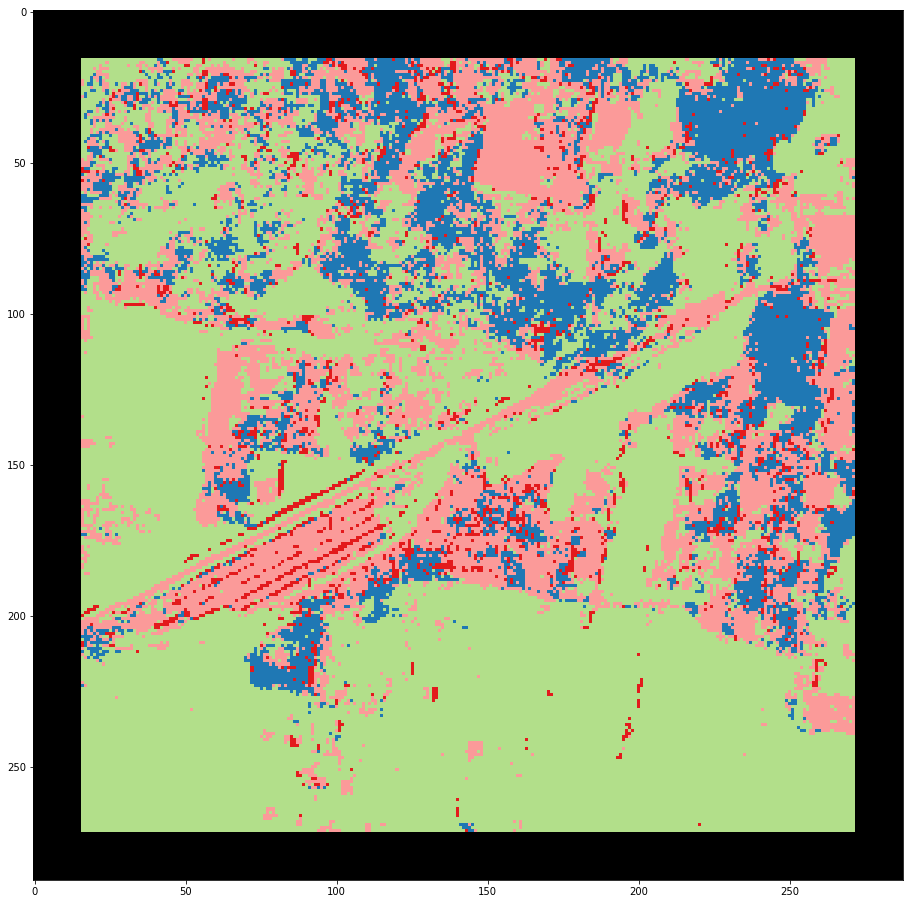

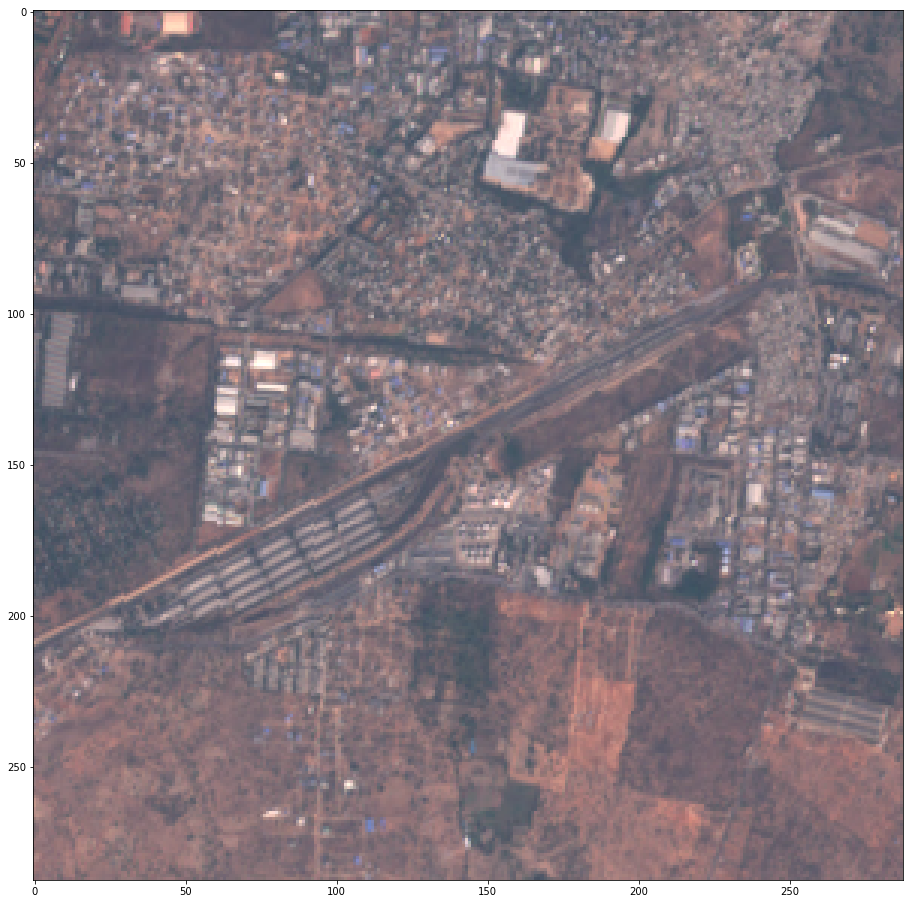

In [14]:
reload(util_workflow)
util_workflow.view_results_tile(data_path, place, 368, model_id, image_suffix)